<img src="https://raw.githubusercontent.com/OGGM/oggm/master/files/logo.png" width="40%"  align="left">

# Getting started with OGGM: Öztal case study

The OGGM workflow is best explained with an example. We are going to use on the testcase that we use for integration testing in oggm. The test files are located in a dedicated online repository, [oggm-sample-data](https://github.com/OGGM/oggm-sample-data).

## Input data

In the `test-workflow` directory you can have a look at the various files we will need. oggm also needs them for testing, so they are automatically available thanks to a simple mechanism:

In [1]:
from oggm.utils import get_demo_file
srtm_f = get_demo_file('srtm_oeztal.tif')
rgi_f = get_demo_file('rgi_oeztal.shp')
print(srtm_f)

/home/mowglie/.oggm/oggm-sample-data-master/test-workflow/srtm_oeztal.tif


The very first time that you make a call to `get_demo_file()`, oggm will create a hidden `.oggm` directory in your home folder$^*$ and download the demo files in it.

<sub>*: this path might vary depending on your platform, see python's [expanduser](https://docs.python.org/3.5/library/os.path.html#os.path.expanduser)</sub>. 

### DEM and glacier outlines

The data directory also contains a subset of the RGI shapefile for Öztal:

In [2]:
import salem  # https://github.com/fmaussion/salem
rgi_shp = salem.utils.read_shapefile(rgi_f).set_index('RGIID')

Let's have a look at it:

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import cleo  # https://github.com/fmaussion/cleo
import shapely.geometry as shpg
# Plot defaults
plt.rcParams['figure.figsize'] = (8, 8)  # Default plot size
import logging
logging.basicConfig(format='%(asctime)s: %(name)s: %(message)s',
                    datefmt='%Y-%m-%d %H:%M:%S', level=logging.INFO)
logger = logging.getLogger()
logger.setLevel(logging.INFO)

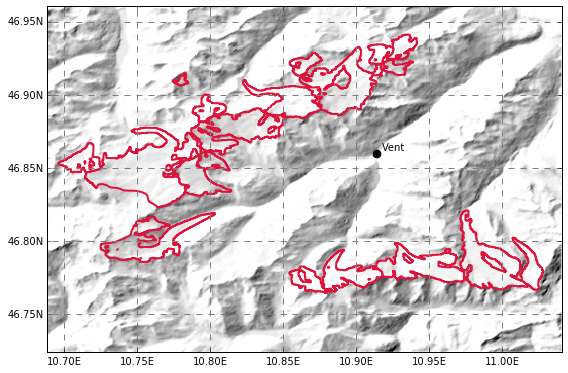

In [6]:
# Open the DEM file
dem = salem.GeoTiff(srtm_f)
# Center the map on the region of interest
dem.set_subset(margin=-80)
cmap = cleo.Map(dem.grid, countries=False)
cmap.set_topography(dem.get_vardata())
# Add a reference point for Vent
cmap.set_geometry(shpg.Point(10.913889, 46.859444), facecolor='k', text='Vent')
# Plot the RGI file
cmap.set_shapefile(rgi_f, edgecolor='crimson', linewidth=2, label='RGI')
cmap.visualize()

### WGMS and GlaThiDa 

These are 19 selected glaciers where we have either mass-balance data (WGMS) or volume information (GlaThiDa). These data are required for calibration/validation and are also available from the test directory:

In [7]:
import pandas as pd
df_gtd = pd.read_csv(get_demo_file('RGI_GLATHIDA_oeztal.csv'))
df_wgms = pd.read_csv(get_demo_file('RGI_WGMS_oeztal.csv'))

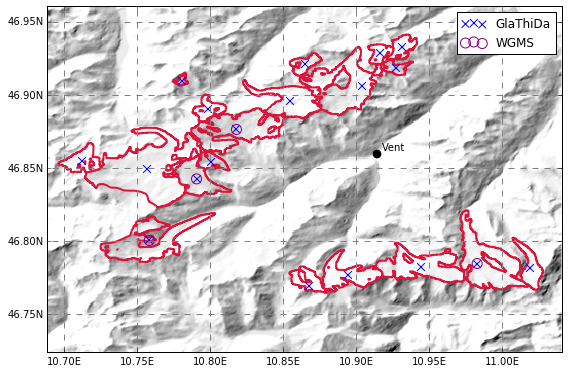

In [8]:
x, y = rgi_shp.loc[df_gtd.RGI_ID].CENLON, rgi_shp.loc[df_gtd.RGI_ID].CENLAT
cmap.set_points(x, y, marker='x', c='blue', label='GlaThiDa')
x, y = rgi_shp.loc[df_wgms.RGI_ID].CENLON, rgi_shp.loc[df_wgms.RGI_ID].CENLAT
cmap.set_points(x, y, marker='o', s=100, facecolor='none', edgecolor='purple', label='WGMS')
cmap.visualize()
plt.legend();

### Climate data

We use HISTALP data which goes back further in time than CRU:

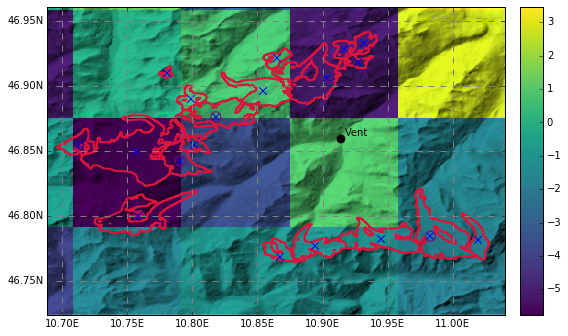

In [9]:
nc = salem.GeoNetcdf(get_demo_file('HISTALP_oeztal.nc'))
t2 = np.mean(nc.get_vardata('temp'), axis=0)
cmap.set_data(t2, nc.grid)
cmap.set_cmap(plt.get_cmap('viridis'))
cmap.set_nlevels(256)
cmap.visualize()

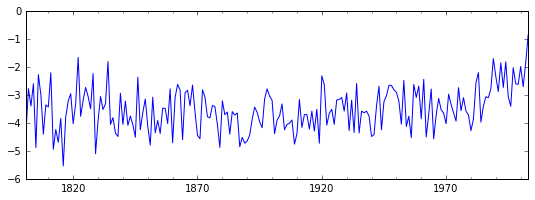

In [10]:
fig = plt.figure(figsize=(9, 3))
pd.Series(nc.get_vardata('temp')[:, 3, 3], index=nc.time).resample('A').plot()

## Setting up an OGGM run

OGGM parameters are gathered in a configuration file. The [default file](https://github.com/OGGM/oggm/blob/master/oggm/params.cfg) is shipped with the code. It is used to initialize the configuration module:

In [11]:
import oggm
import oggm.conf as cfg
from oggm import workflow
cfg.initialize()

INFO:oggm.conf:Parameter file: /home/mowglie/Documents/git/oggm/oggm/params.cfg
INFO:oggm.conf:Working directory: /home/mowglie/OGGM_wd
INFO:oggm.conf:Multiprocessing run


For example, the default working directory is also located in the home directory:

In [13]:
print(cfg.PATHS)

OrderedDict([('working_dir', '/home/mowglie/OGGM_wd'), ('srtm_file', '~'), ('histalp_file', '~'), ('wgms_rgi_links', '~'), ('glathida_rgi_links', '~')])


The necessary data files are missing. Let's set them so that the oggm modules now where to look for the data:

In [14]:
cfg.PATHS['srtm_file'] = get_demo_file('srtm_oeztal.tif')
cfg.PATHS['histalp_file'] = get_demo_file('HISTALP_oeztal.nc')
cfg.PATHS['wgms_rgi_links'] = get_demo_file('RGI_WGMS_oeztal.csv')
cfg.PATHS['glathida_rgi_links'] = get_demo_file('RGI_GLATHIDA_oeztal.csv')

We keep the other parameters to their default values, for example the precipitation scaling factor:

In [15]:
print(cfg.PARAMS['prcp_scaling_factor'])

2.5


This is for the glacier divides (currently only Hintereisferner):

In [16]:
cfg.set_divides_db(get_demo_file('HEF_divided.shp'))

## Glacier working directories

An OGGM run is constituted of several successive tasks to be applied on each glacier. Because these tasks can be computationally and data demanding, they are split in smaller tasks, each of them storing their results in a glacier directory. 

The very first task is always:

In [17]:
# Read in the RGI file
import geopandas as gpd
rgi_file = get_demo_file('rgi_oeztal.shp')
rgidf = gpd.GeoDataFrame.from_file(rgi_file)
# Just in case you do the tutorial for a second time, we delete the content of the directory
cfg.reset_working_dir()
# Initialise directories
gdirs = oggm.workflow.init_glacier_regions(rgidf)

INFO:oggm.prepro.gis:RGI40-11.00648: creating glacier region
INFO:oggm.prepro.gis:RGI40-11.00663: creating glacier region
INFO:oggm.prepro.gis:RGI40-11.00666: creating glacier region
INFO:oggm.prepro.gis:RGI40-11.00670: creating glacier region
INFO:oggm.prepro.gis:RGI40-11.00674: creating glacier region
INFO:oggm.prepro.gis:RGI40-11.00684: creating glacier region
INFO:oggm.prepro.gis:RGI40-11.00687: creating glacier region
INFO:oggm.prepro.gis:RGI40-11.00698: creating glacier region
INFO:oggm.prepro.gis:RGI40-11.00719: creating glacier region
INFO:oggm.prepro.gis:RGI40-11.00746: creating glacier region
INFO:oggm.prepro.gis:RGI40-11.00770: creating glacier region
INFO:oggm.prepro.gis:RGI40-11.00779: creating glacier region
INFO:oggm.prepro.gis:RGI40-11.00787: creating glacier region
INFO:oggm.prepro.gis:RGI40-11.00887: creating glacier region
INFO:oggm.prepro.gis:RGI40-11.00897: creating glacier region
INFO:oggm.prepro.gis:RGI40-11.00929: creating glacier region
INFO:oggm.prepro.gis:RGI

In [18]:
gd = gdirs[0]

In [20]:
print(gd.rgi_date)

2003-07-01 00:00:00


Note that if I run the init_glacier_regions a second time, nothing special happens:

In [ ]:
gdirs = workflow.init_glacier_regions(rgidf)

This is because the directories have been define already. Now what is the variable `gdirs`? It is a list of 19 `oggm.conf.GlacierDir` objects. They are here to help us to handle data I/O:

In [ ]:
gdir = gdirs[13]
print(gdir.dir)
print(gdir.rgi_id)
print(gdir.rgi_date)
print(gdir.glacier_area)
print(gdir.grid.dx)
print(gdir.get_filepath('dem'))

`dem.tif` is a local digital elevation model with a spatial resolution chosen as a function of the size of the model. These GlacierDir objects are going to be the input of almost every OGGM function. It is therefore very easy for the function to get the input it needs from the data stored in the directory. For example, to make a map:

In [ ]:
from oggm import graphics
graphics.plot_googlemap(gdir)

## OGGM tasks

The workflow of OGGM is oriented around the concept of "tasks". There are two different types:

**Entity Task**:
  Standalone operations to be realized on one single glacier entity,
  independently from the others. The majority of OGGM
  tasks are entity tasks. They are parallelisable.

**Global Task**:
  tasks which require to work on several glacier entities
  at the same time. Model parameter calibration or interpolation of degree day factors belong to
  this type of task. They are not parallelisable.
  
OGGM implements a very simple mechanism to run a specific task on a list of `GlacierDir` objects (here, the function `glacier_masks()` from the module `oggm.prepro.gis`):

In [ ]:
workflow.execute_task(oggm.prepro.gis.glacier_masks, gdirs)

It is also possible to apply several tasks sequentially:

In [ ]:
list_talks = [
         oggm.prepro.centerlines.compute_centerlines,
         oggm.prepro.centerlines.compute_downstream_lines,
         oggm.prepro.geometry.catchment_area,
         oggm.prepro.geometry.initialize_flowlines,
         oggm.prepro.geometry.catchment_width_geom,
         oggm.prepro.geometry.catchment_width_correction
         ]
for task in list_talks:
    workflow.execute_task(task, gdirs)

The function `execute_task` can run several tasks in parallel if specified in the configuration file. 

We just computed the glacier flowlines and their width:

In [ ]:
graphics.plot_catchment_width(gdir)

### Global tasks 

We will go into more detail about tasks and global tasks when I have more time to write a good documentation. For now, we will use the helper function:

In [ ]:
workflow.climate_tasks(gdirs)

and:

In [ ]:
workflow.execute_task(oggm.prepro.inversion.prepare_for_inversion, gdirs)

In [ ]:
fs, fd = oggm.prepro.inversion.optimize_inversion_params(gdirs)

## Inversion

We just optimised the parameters **fs** and **fd** required for the glacier thickness inversion. Now we can calculate their thickness:

In [ ]:
vol = []
area = []
for g in gdirs:
    v, a = oggm.prepro.inversion.inversion_parabolic_point_slope(g, fs=fs, fd=fd, write=True)
    vol.append(v)
    area.append(a)
df = pd.DataFrame()
df['area'] = np.array(area) * 1e-6
df['oggm_thick'] = np.array(vol) * 1e-9 / df['area'] * 1000

In [ ]:
graphics.plot_inversion(gdir)

### Statistics

Read in the reference data:

In [ ]:
# Ref data
gtd_df = pd.read_csv(cfg.paths['glathida_rgi_links']).sort_values(by=['RGI_ID'])
# Account for area differences between glathida and rgi
ref_area_km2 = gtd_df.RGI_AREA.values
ref_cs = gtd_df.VOLUME.values / (gtd_df.GTD_AREA.values**1.375)
df['ref_thick'] = ref_cs * ref_area_km2**1.375 / df['area'] * 1000

Add the volume obtained with volume area scaling for comparison: 

In [ ]:
df['vas_thick'] = 0.034*(ref_area_km2**1.375) / df['area'] * 1000

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.scatter(df['ref_thick'], df['oggm_thick'], s=100)
ax1.set_title('OGGM RMSD: {:.2f}'.format(oggm.utils.rmsd(df['ref_thick'], df['oggm_thick'])))
ax1.set_xlabel('Ref thickness')
ax1.set_ylabel('OGGM thickness')
ax1.plot([0, 100], [0, 100], '.:k', zorder=0);
ax1.set_xlim([0, 100]), ax1.set_ylim([0, 100]);
ax2.scatter(df['ref_thick'], df['vas_thick'], s=100)
ax2.set_title('Volume-Area RMSD: {:.2f}'.format(oggm.utils.rmsd(df['ref_thick'], df['vas_thick'])))
ax2.set_xlabel('Ref thickness')
ax2.set_ylabel('VAS thickness')
ax2.plot([0, 100], [0, 100], '.:k', zorder=0);
ax2.set_xlim([0, 100]), ax2.set_ylim([0, 100]);